In [1]:
!pip install -q statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from joblib import dump, load

from utils import check_data_gaps, preprocess_time_series
from feature_generation import Preprocess, create_features, get_feature_names
import warnings
warnings.filterwarnings("error")
jtplot.style()

In [4]:
data = pd.read_csv('data/btc_2021-04-01_2021-04-23_5m.csv', index_col=['date'], parse_dates=['date'])
data = (data
        .resample(rule='5min')
        .asfreq()
        .interpolate(method='time', limit=None))

data['TR'] = np.maximum((data['High'] - data['Low']).abs(), (data['High'] - data['Close'].shift(1).abs()))
data['TR'] = np.maximum(data['TR'], (data['Low'] - data['Close'].shift(1).abs()))
data['ATR'] = data['TR'].rolling(6, min_periods=1).mean()
data['DM'] = (data['High'] - data['Low']) / data['TR'] - ( (data['High'].shift(1) - data['Low'].shift(1)) / data['TR'].shift(1) )

data['DI_plus'] = data['High'] - data['High'].shift(1)
data['DI_minus'] = data['Low'] - data['Low'].shift(1)

data['DI_plus_ind'] = data[(data['DI_plus'] > 0)
                       & (data['DI_plus'].abs() > data['DI_minus'].abs())
                      ]['DI_plus']
data['DI_plus_ind'] = data['DI_plus_ind'].fillna(0)

data['DI_minus_ind'] = -data[(data['DI_minus'] < 0)
                        & (data['DI_plus'].abs() < data['DI_minus'].abs())
                       ]['DI_minus']
data['DI_minus_ind'] = data['DI_minus_ind'].fillna(0)
data['DI_plus_ind'] = data['DI_plus_ind'].rolling(6, min_periods=1).sum() / data['TR'].rolling(6, min_periods=1).sum()
data['DI_minus_ind'] = data['DI_minus_ind'].rolling(6, min_periods=1).sum() / data['TR'].rolling(6, min_periods=1).sum()
data['DI'] = data['DI_plus_ind'] - data['DI_minus_ind']

data['MOMENTUM'] = data['Close'] - data['Close'].shift(2)

data['SUM_up_close'] = data['Close'] - data['Close'].shift(1)
data['SUM_up_close'] = data[data['SUM_up_close'] > 0]['SUM_up_close']
data['SUM_up_close'] = data['SUM_up_close'].fillna(0).rolling(6, min_periods=1).mean()
data['SUM_down_close'] = data['Close'] - data['Close'].shift(1)
data['SUM_down_close'] = -data[data['SUM_down_close'] < 0]['SUM_down_close']
data['SUM_down_close'] = data['SUM_down_close'].fillna(0).rolling(6, min_periods=1).mean()

data['RSI'] = 100 - 100/(1 + (data['SUM_up_close'] / data['SUM_down_close']))

data['X_m'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Beta_1'] = 2 * data['X_m'] - data['High']
data['Sigma_1'] = 2 * data['X_m'] - data['Low']
data['HBOP'] = 2 * data['X_m'] - 2 * data['Low'] + data['High']
data['LBOP'] = 2 * data['X_m'] - 2 * data['High'] + data['Low']

data['SI'] = data['Close'] - data['Close'].shift(1) + 0.5 * ( data['Close'] - data['Open'] ) + 0.25 * ( data['Close'].shift(1) - data['Open'].shift(1))
data['K'] = np.maximum((data['High'] - data['Close'].shift(1)).abs(), (data['Low'] - data['Close'].shift(1).abs()))
data['R1'] = (data['High'] - data['Close'].shift(1)).abs() \
            - 0.5 * (data['Low'] - data['Close'].shift(1)).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R2'] = (data['Low'] - data['Close'].shift(1)).abs() \
            - 0.5 * (data['High'] - data['Close'].shift(1)).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R3'] = (data['High'] - data['Low']).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R_ind_1'] = (data['High'] - data['Close'].shift(1)).abs()
data['R_ind_2'] = (data['Low'] - data['Close'].shift(1)).abs()
data['R_ind_3'] = (data['High'] - data['Low']).abs()

def match_row(frame):
    idx = frame.name

    if frame.idxmax() == 'R_ind_1':
        return data.loc[idx, 'R1']
    elif frame.idxmax() == 'R_ind_2':
        return data.loc[idx, 'R2']
    elif frame.idxmax() == 'R_ind_3':
        return data.loc[idx, 'R3']
    
data['R'] = data[['R_ind_1', 'R_ind_2', 'R_ind_3']].apply(match_row, axis=1)

data['SI'] = (50 * data['SI'] / data['R'] * data['K']).round()

data.drop(['DI_plus', 'DI_minus', 'DI_plus_ind', 'DI_minus_ind', 'SUM_up_close', 'SUM_down_close', 'K', 'R1', 'R2', 'R3', 'R_ind_1', 'R_ind_2', 'R_ind_3', 'R'], axis=1, inplace=True)
data.fillna(0, inplace=True)

cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'X_m', 'Beta_1', 'Sigma_1', 'HBOP', 'LBOP']
for col in cols_to_scale:
    data[col] = np.log(data[col] + 1)
    
X_data = data.reset_index(drop=True)
np.seterr(invalid='raise')

X_features, y = create_features(data_raw=X_data,
                                fs=1,
                                segment_window=12*24,
                                partitioning=True,
                                window_length=12*24,
                                label_length=12*4,
                                stride= 12*4,
                                subsample_factor= 1,
                                binary_delta_labels=True,
                                binary_delta_value='Close')

if np.where(np.isnan(X_features))[0].shape[0] > 0:
    print('NAN Values')
    
feature_names = get_feature_names(raw_names=X_data.columns)
X_features = pd.DataFrame(X_features, columns=feature_names)
print(f'Data shape: {X_features.shape}, labels shape: {y.shape}, feature names: {len(feature_names)}')

Data shape: (128, 2633), labels shape: (128,), feature names: 2633


In [4]:
warnings.filterwarnings("default")
FEATURES_PATH = 'saved_models/feature_list_v3.joblib'
MODEL_PATH = 'saved_models/classification_model_BTC_v3.joblib'

feature_list = load(FEATURES_PATH)
model = load(MODEL_PATH)
X_features = X_features[feature_list]
data_probs = model.predict_proba(X_features)[:, 1]

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*3,
                                           stride=12*3,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')

plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()

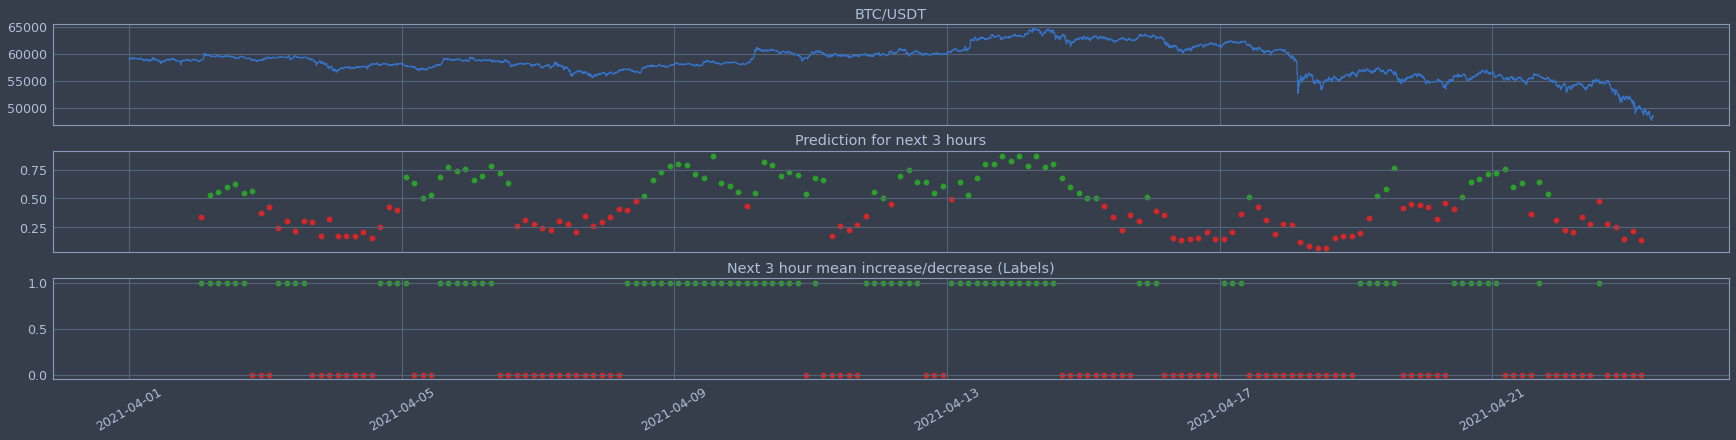

In [6]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax[1].scatter(plot_ticks[data_probs > 0.5], data_probs[data_probs > 0.5], c='tab:green')
ax[1].scatter(plot_ticks[data_probs < 0.5], data_probs[data_probs < 0.5], c='tab:red')
ax[1].scatter(plot_ticks[data_probs == 0.5], data_probs[data_probs == 0.5], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax[2].scatter(plot_ticks[y > 0.5], y[y > 0.5], c='tab:green')
ax[2].scatter(plot_ticks[y < 0.5], y[y < 0.5], c='tab:red')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
# ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_tick_params(rotation = 30)
# plt.gca().set_xbound('2021-03-17 12:00:00', '2021-03-18 12:00:00')
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        88
           1       0.74      0.72      0.73        82

    accuracy                           0.74       170
   macro avg       0.74      0.74      0.74       170
weighted avg       0.74      0.74      0.74       170



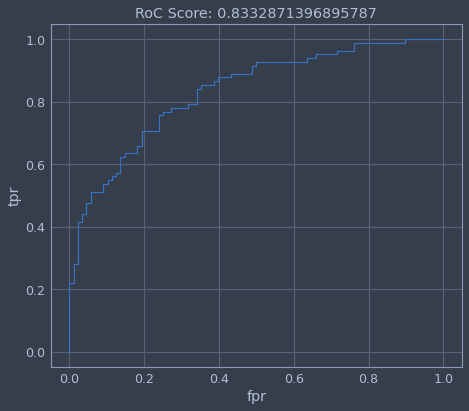

In [7]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

report = classification_report(y, data_probs > 0.5)
print(report)

roc = roc_auc_score(y, data_probs)
fpr, tpr, _ = roc_curve(y, data_probs)
fig, ax = plt.subplots(1,1, constrained_layout=True)
ax.plot(fpr, tpr)
ax.set_title(f'RoC Score: {roc}')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.show()

In [24]:
warnings.filterwarnings("default")
FEATURES_PATH = 'saved_models/feature_list_v7.joblib'
MODEL_PATH = 'saved_models/classification_model_BTC_v7.joblib'

feature_list = load(FEATURES_PATH)
model = load(MODEL_PATH)
X_features = X_features[feature_list]
data_probs = model.predict_proba(X_features)
data_predictions= model.predict(X_features)

In [20]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*4,
                                           stride=12*4,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')

plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()

In [21]:
Y = y[1:] - y[:-1] + 1

In [22]:
data_labels = Y

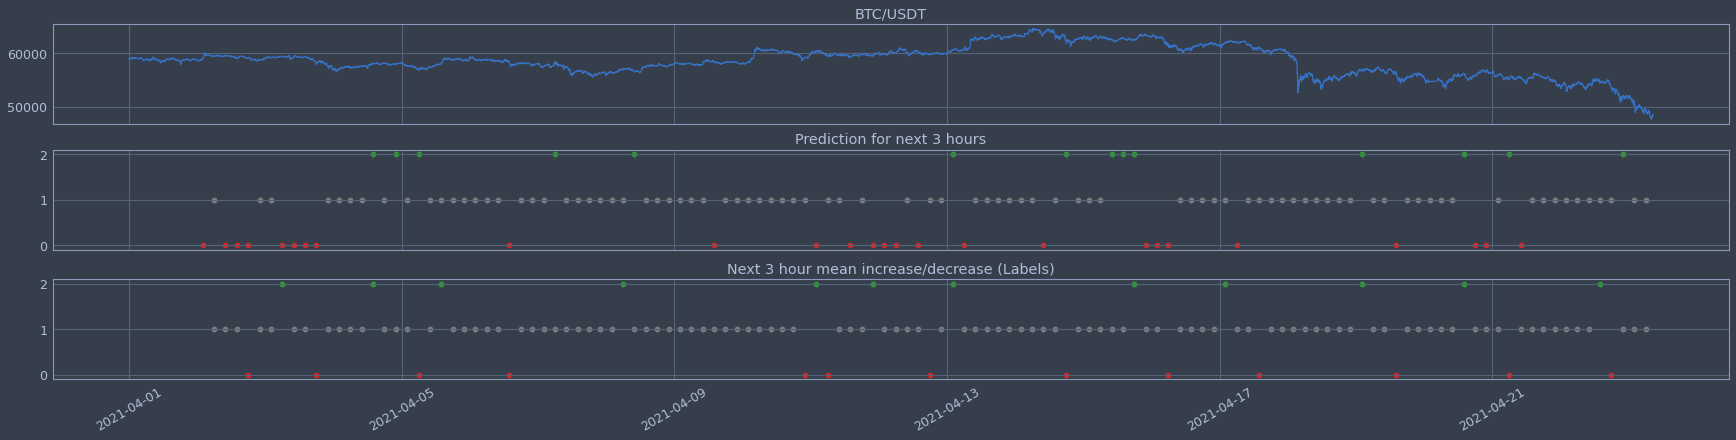

In [23]:
jtplot.style()
data_probs_class = np.argmax(data_probs.reshape(-1, 3), axis=1)
fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 2], data_probs_class[data_probs_class == 2], c='tab:green')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 0], data_probs_class[data_probs_class == 0], c='tab:red')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 1], data_probs_class[data_probs_class == 1], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 2], data_labels[data_labels == 2], c='tab:green')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 0], data_labels[data_labels == 0], c='tab:red')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 1], data_labels[data_labels == 1], c='tab:gray')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
plt.gca().xaxis.set_tick_params(rotation = 30)
# plt.gca().set_xbound('2021-02-21', '2021-03-07')
plt.show()

In [27]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

report = classification_report(data_labels, data_predictions[1:])
print(report)

              precision    recall  f1-score   support

           0       0.20      0.38      0.26        13
           1       0.90      0.77      0.83       102
           2       0.36      0.42      0.38        12

    accuracy                           0.70       127
   macro avg       0.48      0.53      0.49       127
weighted avg       0.78      0.70      0.73       127

